In [9]:
from SALib.sample import saltelli
from scipy.stats import pearsonr
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import lzma
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
os.chdir("../")
import cpt_optimisation

In [4]:
def GINI(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    mean = np.mean(x) or 1
    rmad = mad/mean
    g = 0.5 * rmad
    return g

In [5]:
result = {i:{"deg":[], "med_w":[], "gini":[], "avg_w":[]} for i in range(3)}

start_t = time.time()

for seed_folder in os.listdir("DATA/nodebt/"):
    print(f"{time.time()-start_t:.2f} | {seed_folder}")
    
    if "DS_" in seed_folder:
        continue

    seed = int(seed_folder.split("_")[-1])
    files = os.listdir(f"DATA/nodebt/{seed_folder}")
    
    for f in tqdm(files):
        param_idx = int(f.split("_")[1]) - 1
        data = pickle.load(lzma.open(f"DATA/nodebt/{seed_folder}/{f}"))
        alpha_val = data["params"][4]
        data_W = data["W"]

        # retrieve communities from graph
        with open(f"sda_graphs/{seed}_{alpha_val}.pickle", "rb") as f:
            communities, community_membership, _, _ = pickle.load(f)
        NC = len(communities)
            
        deg = []
        med_w = []
        avg_w = []
        gini = []
        
        COMMUNITY_W = np.zeros((NC, 101))
        for i,c in enumerate(communities):
            
            # get final community wealth
            comm_w = data_W[:, np.array(list(c))]
            
            # compute average final community wealth
            mean_comm_w = np.mean(comm_w, axis=1)
            COMMUNITY_W[i] = mean_comm_w
            
            # compute median and average community wealth, and gini
            med_w.append(np.median(comm_w[-1]))
            avg_w.append(mean_comm_w[-1])
            
            w_rounded = comm_w[-1].astype(np.float64).round(2)
            
            gini.append(GINI(w_rounded))
            
            # determine community degree
            d = set()
            for agent in c:
                for item in community_membership[agent]:
                    d.add(item)
            deg.append(len(d))
        
        # determine regime
        prop_richer = sum(data_W[-1] > data_W[0]) / 1225
        assert 0 <= prop_richer <= 1
        
        if prop_richer == 0:
            regime = 0
        elif prop_richer < 1:
            regime = 1
        else:
            regime = 2
        
        result[regime]["deg"] += deg
        result[regime]["avg_w"] += avg_w
        result[regime]["med_w"] += med_w
        result[regime]["gini"] += gini

0.00 | new_model_runs_paper_14


  0%|          | 0/7168 [00:00<?, ?it/s]

929.59 | new_model_runs_paper_13


  0%|          | 0/7168 [00:00<?, ?it/s]

1837.32 | new_model_runs_paper_12


  0%|          | 0/7168 [00:00<?, ?it/s]

2746.52 | new_model_runs_paper_15


  0%|          | 0/7168 [00:00<?, ?it/s]

3649.70 | .DS_Store
3649.70 | new_model_runs_paper_0


  0%|          | 0/7168 [00:00<?, ?it/s]

4567.95 | new_model_runs_paper_7


  0%|          | 0/7168 [00:00<?, ?it/s]

5487.57 | new_model_runs_paper_9


  0%|          | 0/7168 [00:00<?, ?it/s]

6401.14 | new_model_runs_paper_8


  0%|          | 0/7168 [00:00<?, ?it/s]

7337.01 | new_model_runs_paper_6


  0%|          | 0/7168 [00:00<?, ?it/s]

8277.43 | new_model_runs_paper_1


  0%|          | 0/7168 [00:00<?, ?it/s]

9247.76 | new_model_runs_paper_19


  0%|          | 0/7168 [00:00<?, ?it/s]

10199.98 | new_model_runs_paper_10


  0%|          | 0/7168 [00:00<?, ?it/s]

11174.62 | new_model_runs_paper_17


  0%|          | 0/7168 [00:00<?, ?it/s]

12160.91 | new_model_runs_paper_16


  0%|          | 0/7168 [00:00<?, ?it/s]

13161.73 | new_model_runs_paper_11


  0%|          | 0/7168 [00:00<?, ?it/s]

14148.24 | new_model_runs_paper_18


  0%|          | 0/7168 [00:00<?, ?it/s]

15157.97 | new_model_runs_paper_4


  0%|          | 0/7168 [00:00<?, ?it/s]

16173.38 | new_model_runs_paper_3


  0%|          | 0/7168 [00:00<?, ?it/s]

17188.65 | new_model_runs_paper_2


  0%|          | 0/7168 [00:00<?, ?it/s]

18210.30 | new_model_runs_paper_5


  0%|          | 0/7168 [00:00<?, ?it/s]

In [7]:
with open("comm_deg_median_w.pickle", "wb") as f:
    pickle.dump(result, f)

# Results

In [5]:
with open("comm_deg_median_w.pickle", "rb") as f:
    result = pickle.load(f)

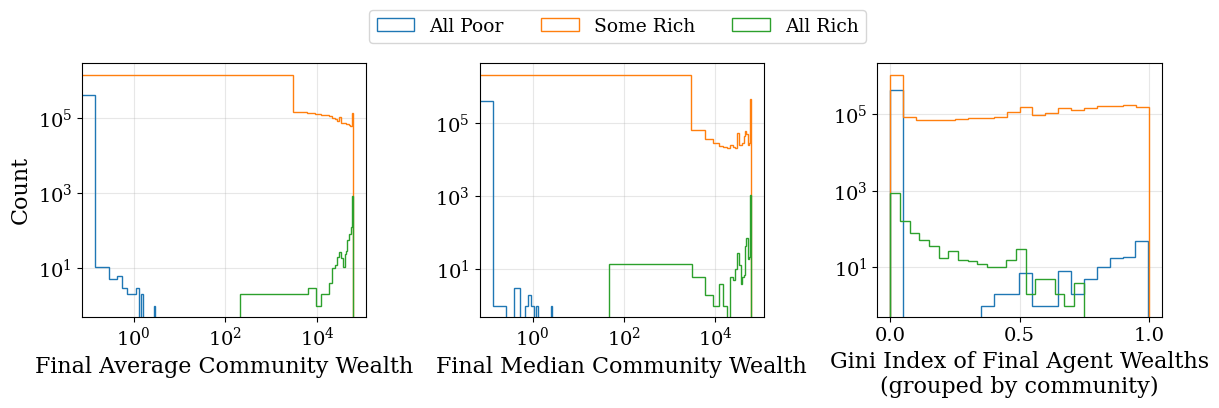

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
regime_name = {0:"All Poor", 1:"Some Rich", 2:"All Rich"}
xlabels = {"avg_w":"Final Average Community Wealth", 
           "med_w":"Final Median Community Wealth", 
           "gini":"Gini Index of Final Agent Wealths\n(grouped by community)"}

for i,metric in enumerate(["avg_w", "med_w", "gini"]):
    for regime in [0, 1, 2]:
        if i == 2:
            vals = [x for x in result[regime][metric] if 0 <= x <= 1]
            axs[i].hist(vals, histtype="step", bins=20, label=regime_name[regime])
        else:
            axs[i].hist(result[regime][metric], histtype="step", bins=20)

    if metric != "gini":
        axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    
    if i == 0:
        axs[i].set_ylabel("Count")
    axs[i].set_xlabel(xlabels[metric])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.4)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.74, 1.05), ncol=3)
plt.savefig("community_distributions.pdf", bbox_inches="tight")
plt.show()

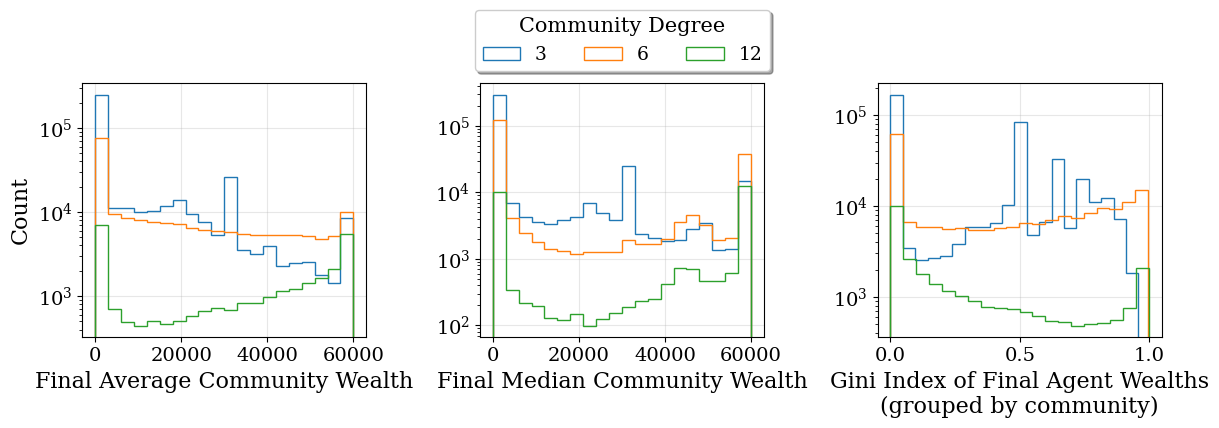

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
REGIME = 1
xlabels = {"avg_w":"Final Average Community Wealth", 
           "med_w":"Final Median Community Wealth", 
           "gini":"Gini Index of Final Agent Wealths\n(grouped by community)"}

for i, key in enumerate(["avg_w", "med_w", "gini"]):
    for deg in [3, 6, 12]:
        x = [result[REGIME][key][i] for i in range(len(result[REGIME][key])) if result[REGIME]["deg"][i]==deg]
        if key == "gini":
            x = [val for val in x if 0 <= val <= 1]
        axs[i].hist(x, bins=20, label=deg, histtype="step")

    axs[i].set_yscale("log")
    
    if i == 0:
        axs[i].set_ylabel("Count")
    axs[i].set_xlabel(xlabels[key])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.4)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.66, 1.1), ncol=3, title="Community Degree", shadow=True)

plt.savefig("community_degree_distributions.pdf", bbox_inches="tight")
plt.show()